In [1]:
import numpy as np
np.random.seed(0)

In [2]:
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy
from tqdm.notebook import tqdm

In [3]:
class Layer:
    def __init__(self,input_dim,output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.W = 0.10 * np.random.randn(output_dim,input_dim)
        self.X = None
    def forward(self,input):
        pass
    def backward(self,output_grad,lr):
        pass
    def __repr__(self):
        pass
    
class HiddenLayer(Layer):
    def __init__(self,input_dim,output_dim,activation):
        super().__init__(input_dim,output_dim)
        self.b = np.random.randn(output_dim,1)
        self.activation = activation
                
    def forward(self,X,  training = True):
        # save x only if learning
        if training:
            self.X = X
       # print('X'+str(X.shape))
        #print('W'+str(self.W.shape))
        #print('b'+str(self.b.shape))
        z = self.W @ X + self.b
        # send to activation function
        out = self.activation.forward(z)
        return out
    
    def backward(self,v,lr, test = None):
       # grad_W, grad_X, grad_b = self.activation.backward( v,self.X,self.W,self.b)
        # for gradient test only!
        if test:
            grad_W, grad_X, grad_b = self.activation.backward( v,self.X,self.W,self.b,test)
            return grad_W, grad_X, grad_b
        else:
            grad_W, grad_X, grad_b = self.activation.backward( v,self.X,self.W,self.b)
            
        self.W -= lr*grad_W
       # print('b'+str(self.b.shape))
       # print('grad_b'+str(grad_b.shape))
        self.b -= lr*grad_b
        v = grad_X
        return v 
    def __repr__(self):
        rep = 'HiddenLayer' + str((self.input_dim,self.output_dim))
        return rep
class OutputLayer(Layer):
    def __init__(self,input_dim,output_dim,loss_f):
        super().__init__(input_dim,output_dim)
        self.loss_f = loss_f

                
    def forward(self,X, training = True):
        if training:
            self.X = X
        out = self.loss_f.forward(X,self.W)
        return out
    
    
    def backward(self,C,lr):
        grad_W, grad_X = self.loss_f.backward(self.X,self.W,C)
       # print("W"+ str(self.W.shape))
       # print("grad_W"+ str(grad_W.shape))
        self.W -= lr*grad_W.T
        v = grad_X
        return v 

    def get_loss(self,X,C):
      #  print(self.loss_f.calc_loss(self.X, C)  )
        return self.loss_f.calc_loss(X, C)    
    def __repr__(self):
        rep = 'OutputLayer' + str((self.input_dim,self.output_dim))
        return rep

In [4]:
class ResNetLayer(HiddenLayer):
    def __init__(self,dim ,activation):
        super().__init__(dim,dim,activation)
        self.activation = activation
        self.W2 = 0.10 * np.random.randn(dim,dim)
        
                
    def forward(self,X,  training = True):
        z = super().forward(X,  training )
        out = X + self.W2 @ z
        return out
    
    def backward(self,v,lr):
       # print("W2.T" + str(self.W2.T.shape))
       # print("V" + str(v.shape))
        W2v = self.W2.T @ v
        grad_W,grad_X,grad_b = self.activation.backward( W2v,self.X,self.W,self.b)
        self.W -= lr*grad_W 
        
        z = self.W @ self.X + self.b

     #   print("W2" + str(print(self.W2.shape)))
     #   print("V" + str(print(v.shape)))
        self.W2 -= lr*(v @ self.activation.forward(z).T )
        grad_X = v + grad_X 
       # print('b'+str(self.b.shape))
       # print('grad_b'+str(grad_b.shape))
        self.b -= lr*grad_b
        v = grad_X
        return v
    def __repr__(self):
        rep = 'ResNetLayer' + str((self.input_dim,self.output_dim))
        return rep

In [5]:
class Activation:
    def __init__(self,activation,activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
        self.z = None
        
    def forward(self,z):
        self.z = z        
      #  print('tanh'+str(self.activation(self.z).shape))
        return self.activation(self.z)
    
    def backward(self, v,X,W,b, test = None):
       # print("self.activation_prime(self.z)" + str(self.activation_prime(self.z).shape))
       # print("v" + str(v.shape))
        activation_p = self.activation_prime(self.z)
        grad = np.multiply(activation_p,v)

        if test=='test W':
            grad_X = None
            grad_W = np.multiply(activation_p ,(v @ X ))
            
        elif test=='test X':
            grad_X = np.multiply(activation_p ,(W @ v ))
            grad_W = None
            
        else:
            grad_X = W.T @ grad
            grad_W = grad @ X.T
            

            
        grad_b = np.sum(grad,axis = 1).reshape(-1,1)
     #   print("grad_b" + str(grad_b.shape))
     #   print("grad_X" + str(grad_X.shape))
     #   print("grad_W" + str(grad_W.shape))
        return grad_W,grad_X,grad_b
    
class Tanh(Activation):
    def __init__(self):
        tanh = lambda x: np.tanh(x)
        tanh_prime = lambda x:1-np.tanh(x)**2
        super().__init__(tanh,tanh_prime)

In [6]:
class Softmax:
    def __init__(self):
      #  self.X = None 
       # self.w = None  
        self.out = None
        
    def forward(self,X,W):
        product_Xw = X.T @ W.T
        exp = np.exp(product_Xw - np.max(product_Xw ))
        div = np.divide(exp, np.sum(exp, axis = 1).reshape(-1,1))
        self.out = div 
        return self.out
        
    def calc_loss(self,X, C):
        #cross entrophy loss
        log  = np.log(self.out)
        m = len(X[0])
        return -np.sum(C*log)/m  
    
    def backward(self,X,W, C):
        m = len(X[0])
       # print('softmax-out '+ str((self.out).shape))
      #  print('C'+ str((C).shape))
       # print('X'+ str((X).shape))
        sub =  self.out - C
        grad_W  = (1/m)*(X @ sub)
        grad_X  = (1/m)*(W.T @ sub.T)
        return  grad_W, grad_X



In [7]:
class Net:
    def __init__(self,layers,lr=0.01):
        self.lr = lr
        self.layers = layers
        self.loss = 0
    
    def forward(self,X,C = None, training = True, update_loss = True):
        '''
        forward pass of the network
        '''
        output = X
        for layer in self.layers:
            output = layer.forward(output, training)
         
        if update_loss:
            batch_loss = self.layers[-1].get_loss(output, C)
            self.loss += batch_loss
        return output
    

    def backward(self,C):
        '''
        backward pass through the network + updating params
        '''
        
        v = self.layers[-1].backward(C,self.lr)
        
        for layer in np.flip(self.layers[:-1]):
          #  print('v' + str(v.shape))
            v = layer.backward(v, self.lr)
            
    def predict(self,X):
        prob = self.forward(X,training = False, update_loss = False)
        output = (prob == prob.max(axis=1)[:,None]).astype(int)
        return output


In [8]:
def accuracy(pred, true):
    div = np.divide(pred + true,2).astype(int)
    output = np.sum(div)/len(div)
    return output

In [9]:
def data_loader(file_name):
    mat = scipy.io.loadmat(file_name)
    Xtrain = mat.get('Yt')
    # for the bias 
    Ytrain = mat.get('Ct')
    Xtest = mat.get('Yv')
    Ytest = mat.get('Cv')
    return Xtrain, Ytrain, Xtest, Ytest

datasets = ["GMMData","PeaksData","SwissRollData"]

# Xtrain, Ytrain, Xtest, Ytest = data_loader(datasets[1])
# feature_num,examples_num = Xtrain.shape
# labels_num = Ytrain.shape[0]

# train_acc=[]
# test_acc=[]
# train_loss = []

In [333]:
Ytrain.shape,Xtrain.shape

((5, 25000), (2, 25000))

In [334]:
epocs = 50
lr = 0.1
batch_size = 64
input_dim = feature_num
output_dim = labels_num
hidden_dim = 6 # number of neurons at each layer (fixed for all layers)
resnet_dim = 6

In [335]:
input_dim,output_dim

(2, 5)

In [336]:
nn = Net(layers = [HiddenLayer(2,6,Tanh()),
                   HiddenLayer(6,6,Tanh()),
                   HiddenLayer(6,6,Tanh()),
                   OutputLayer(6,5,Softmax())]
                , lr = lr)

In [301]:
nn = Net(layers = [HiddenLayer(5,6,Tanh()),
                   HiddenLayer(6,8,Tanh()),
                   HiddenLayer(8,10,Tanh()),
                   HiddenLayer(10,6,Tanh()),
                   HiddenLayer(6,6,Tanh()),
                   OutputLayer(6,5,Softmax())]
                , lr = lr)

In [302]:
nn = Net(layers = [HiddenLayer(5,6,Tanh()),
                   HiddenLayer(6,8,Tanh()),
                   ResNetLayer(8,Tanh()),
                   ResNetLayer(8,Tanh()),
                   HiddenLayer(8,6,Tanh()),
                   OutputLayer(6,5,Softmax())]
                , lr = lr)

In [337]:
%%time



# Train loop
a_t = []
a_v = []
train_accuracy =[]
val_accuracy =[]
training_loss = []
val_loss =[]
for epoc in tqdm(range(epocs)):
    # Shuffle train data
    indices = np.arange(examples_num)
    np.random.shuffle(indices)
    Xtrain = Xtrain[:,indices]
    Ytrain = Ytrain[:,indices]
    i = 0
    nn.loss = 0
    while i * batch_size < examples_num:
        # Obtain minibatch
        batch_start = i * batch_size
        batch_end = min((i + 1) * batch_size, examples_num)
        
        minix = Xtrain[:,batch_start:batch_end]
        # transpoce the miniy to be inline with C
        miniy = Ytrain[:,batch_start:batch_end].T
        a_t.append(batch_end-batch_start)
        #forward pass
        nn.forward(minix,miniy)

        #Backward+update nn params
        nn.backward(miniy)
        
        #next batch...
        i += 1
        
    bias_fix = (i * batch_size - examples_num)/batch_size
    training_loss.append(nn.loss/(i-1+bias_fix))
    train_accuracy.append(accuracy(nn.predict(Xtrain),Ytrain.T))
    #training_loss.append(nn.loss)
    
    # validation
    
    examples_num = Xtest.shape[1]
    indices = np.arange(examples_num)
    np.random.shuffle(indices)
    Xtest = Xtest[:,indices]
    Ytest = Ytest[:,indices]
    j = 0
    nn.loss = 0
    
    while j * batch_size < examples_num:
        # Obtain minibatch
        batch_start = j * batch_size
        batch_end = min((j + 1) * batch_size, examples_num)
        
        minix = Xtest[:,batch_start:batch_end]
        # transpoce the miniy to be inline with C
        miniy = Ytest[:,batch_start:batch_end].T
        a_t.append(batch_end-batch_start)
        #forward pass
        nn.forward(minix,miniy, training=False )
        
        #next batch...
        j += 1
    #val_loss.append(nn.loss)
    bias_fix = (j * batch_size - examples_num)/batch_size
    val_loss.append(nn.loss/(j-1+bias_fix))
    val_accuracy.append(accuracy(nn.predict(Xtest),Ytest.T))
    
    
#    nn.loss = 0
 #   nn.forward(Xtest,Ytest.T)
  #  val_loss.append(nn.loss)

  0%|          | 0/50 [00:00<?, ?it/s]

Wall time: 2.53 s


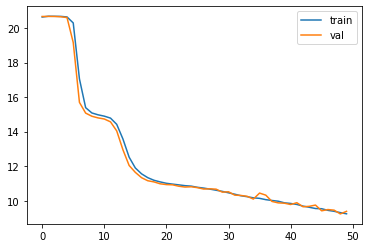

In [338]:
plt.plot(training_loss)
plt.plot(val_loss)
plt.legend(["train", "val"])
plt.show()

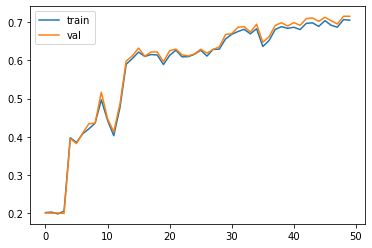

In [339]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.legend(["train", "val"])
plt.show()

In [340]:
val_accuracy[-1],train_accuracy[-1]

(0.71536, 0.70528)

In [68]:
def jac_test(test, resnet = False, x = None,input_dim = None,output_dim = 5,layer = None, v=None):
    d = np.random.rand(3, 3)
    
    if x == None:
        input_dim = 3
        output_dim = 3
        x = np.random.rand(3, 3)
        if test == 'test b':
            d = np.random.rand(3, 1)
            x = np.random.rand(3, 1)            
        layer = HiddenLayer(3, 3, Tanh())
        
    d = d / np.linalg.norm(d)
    x_input = x
    eps_num = 10
    eps_vals = [0.5**i for i in range(1,eps_num+1)]
    Oϵ, Oϵ2 = [], []
    
    fx = layer.forward(x)
    if test =='test W':
        w = layer.W
    elif test == 'test b':
        b= layer.b
    
    test_dict = {"test b": 0, "test W": 0, "test X":0}
    
    for eps in eps_vals:
        eps_d = eps * d
        
        if test =='test W':
            layer.W = np.add(w, eps_d)
        if test == 'test b':
            layer.b = np.add(b, eps_d)
        if test == 'test X':
            x_input = np.add(x, eps_d)
            
        fx_d = layer.forward(x_input)
        
        test_dict["test W"],test_dict["test X"],test_dict["test b"] = layer.backward(eps_d,0.001,test)

        
        first_ord = fx_d - fx
        second_ord = first_ord - test_dict[test]
        
        Oϵ.append(np.linalg.norm(first_ord))
        Oϵ2.append(np.linalg.norm(second_ord))
    return Oϵ,Oϵ2


In [69]:
def make_plot_test(Oϵ, Oϵ2, name):
    f,ax = plt.subplots(figsize=(3,4))
    ax.semilogy(range(len(Oϵ)), Oϵ, label='First Order')
    ax.semilogy(range(len(Oϵ2)), Oϵ2, label='Second Order')
    ax.legend()
    ax.set_title('jacMV '+ name) 
    return ax
    

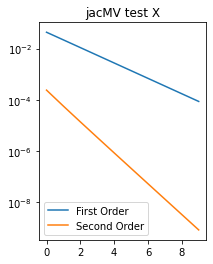

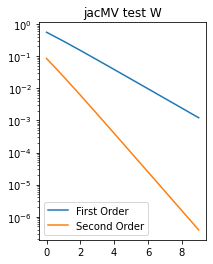

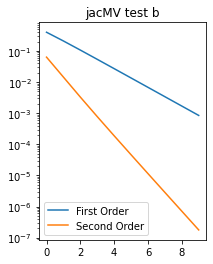

In [70]:
test = ['test X','test W','test b']
for test in test:
    Oϵ, Oϵ2 =  jac_test(test)
    make_plot_test(Oϵ, Oϵ2, name=test)

In [71]:
def softmax_jac_test(test,X,C,layer):
    
    # number of dimensions (features)
    n = X.shape[0]
    # number of labels
    l = C.shape[1]
    # batch size
    b = X.shape[1]
    
    if test=='test W':
        d = np.random.rand(l,n)
    if test=='test X':
        d = np.random.rand(n,b)
    d = d/np.linalg.norm(d,ord = 1, axis = 0)
    
    w = np.random.rand(l,n)    
    layer.W = w
    layer.forward(X)
    
    grad_dict = {"test W": 0, "test X":0}
    loss = layer.loss_f.calc_loss(X, C)

    # keep the initial weights aside
    W = layer.W

    grad_dict["test W"],grad_dict["test X"] = layer.loss_f.backward(X,W, C)
    grad = grad_dict[test]
    if test == 'test W':
        grad = grad.T
        
    Oϵ= []
    Oϵ2 = []
   # eps_list = []
    
    eps = 0.5
    test_range = list(range(20))
    for i in test_range:
        if test == 'test W':
            layer.W = W + eps*d
            layer.forward(X,training = False)
 
        if test == 'test X':
            layer.loss_f.forward(X+ eps*d,W )
            
        loss_d = layer.loss_f.calc_loss(X, C)
        
        Oϵ.append(abs(loss_d  - loss ) )
        Oϵ2.append(abs(loss_d  - loss - (d * eps).ravel() @ grad.ravel()))
      #  eps_list.append(eps)
        eps *= 0.5
        
    return Oϵ, Oϵ2


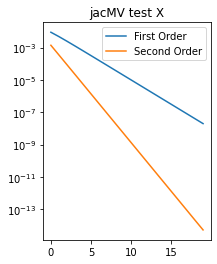

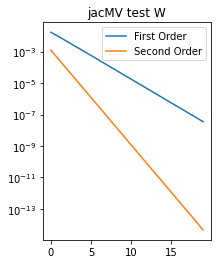

In [72]:
layer = OutputLayer(6,3,Softmax())

C = np.array([[0,1,0],[0,0,1],[0,0,1],[1,0,0],[1,0,0],[1,0,0]])

X = np.random.rand(6,6)

tests = ['test X','test W']
for test in tests:
    Oϵ, Oϵ2 =  softmax_jac_test(test, X=X, C = C , layer = layer)
    make_plot_test(Oϵ, Oϵ2, name=test)


# Whole nn test

In [159]:
def jac_test_layer(test, layer = None):
    if test == 'test b':
        d = np.random.rand(layer.input_dim, 1)
    else :
        d = np.random.rand(layer.input_dim, layer.output_dim)        
        
    d = d / np.linalg.norm(d)
    x = layer.X
    x_input = x
    eps_num = 10
    eps_vals = [0.5**i for i in range(1,eps_num+1)]
    Oϵ, Oϵ2 = [], []
    
    fx = layer.forward(x,training=False)
    if test =='test W':
        w = layer.W
    elif test == 'test b':
        b= layer.b
    
    test_dict = {"test b": 0, "test W": 0, "test X":0}
    
    for eps in eps_vals:
        eps_d = eps * d
        
        if test =='test W':
            layer.W = np.add(w, eps_d)
        if test == 'test b':
            layer.b = np.add(b, eps_d)
        if test == 'test X':
            x_input = np.add(x, eps_d)
            
        fx_d = layer.forward(x_input,training=False)
        
        test_dict["test W"],test_dict["test X"],test_dict["test b"] = layer.backward(eps_d,0.001,test)

        
        first_ord = fx_d - fx
        second_ord = first_ord - test_dict[test]
        
        Oϵ.append(np.linalg.norm(first_ord))
        Oϵ2.append(np.linalg.norm(second_ord))
    return Oϵ,Oϵ2


In [162]:
def softmax_jac_test_layer(test,C,layer):
    X = layer.X
    # number of dimensions (features)
    n = X.shape[0]
    # number of labels
    l = C.shape[1]
    # batch size
    b = X.shape[1]
    
    if test=='test W':
        d = np.random.rand(l,n)
    if test=='test X':
        d = np.random.rand(n,b)
    d = d/np.linalg.norm(d,ord = 1, axis = 0)
    
    w = np.random.rand(l,n)    
    layer.W = w
    layer.forward(X,training=False)
    
    grad_dict = {"test W": 0, "test X":0}
    loss = layer.loss_f.calc_loss(X, C)

    # keep the initial weights aside
    W = layer.W

    grad_dict["test W"],grad_dict["test X"] = layer.loss_f.backward(X,W, C)
    grad = grad_dict[test]
    if test == 'test W':
        grad = grad.T
        
    Oϵ= []
    Oϵ2 = []
   # eps_list = []
    
    eps = 0.5
    test_range = list(range(20))
    for i in test_range:
        if test == 'test W':
            layer.W = W + eps*d
            layer.forward(X,training = False)
 
        if test == 'test X':
            layer.loss_f.forward(X+ eps*d,W )
            
        loss_d = layer.loss_f.calc_loss(X, C)
        
        Oϵ.append(abs(loss_d  - loss ) )
        Oϵ2.append(abs(loss_d  - loss - (d * eps).ravel() @ grad.ravel()))
      #  eps_list.append(eps)
        eps *= 0.5
        
    return Oϵ, Oϵ2


In [193]:
epocs = 4
lr = 0.1
batch_size = 1
input_dim = feature_num
output_dim = labels_num

nn = Net(layers = [HiddenLayer(5,5,Tanh()),
                   HiddenLayer(5,5,Tanh()),
                   OutputLayer(5,5,Softmax())],
                   lr = lr)

indices = np.arange(examples_num)
np.random.shuffle(indices)
Xtrain = Xtrain[:,indices]
Ytrain = Ytrain[:,indices]

batch_start = 0
batch_end =  batch_size

minix = Xtrain[:,batch_start:batch_end]
miniy = Ytrain[:,batch_start:batch_end].T

nn.forward(minix,miniy);

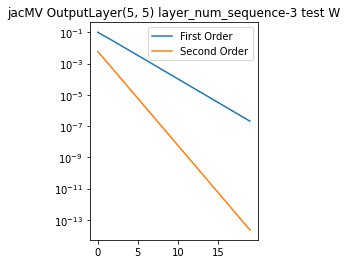

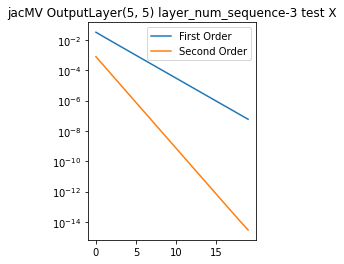

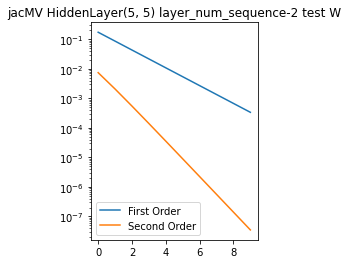

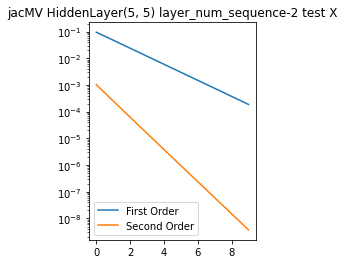

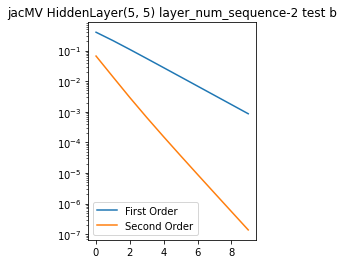

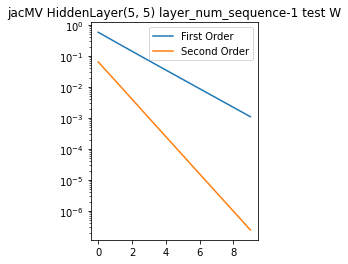

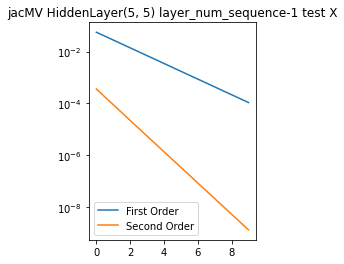

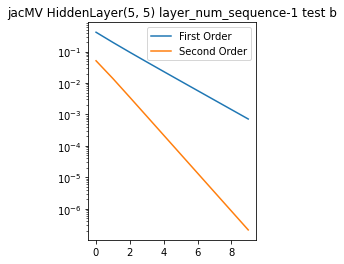

In [198]:
i = len(nn.layers)
for layer in reversed(nn.layers):
    if isinstance(layer,OutputLayer):
        tests = ['test W','test X'] 
        for test in tests:
            Oϵ,Oϵ2 = softmax_jac_test_layer(test,miniy,layer)
            make_plot_test(Oϵ,Oϵ2,str(layer)+f' layer_num_sequence-{i} '+test)
    else:
        tests = ['test W','test X','test b']
        for test in tests:
            Oϵ,Oϵ2 = jac_test_layer(test,layer)
            make_plot_test(Oϵ,Oϵ2,str(layer)+f' layer_num_sequence-{i} '+test)
        
    i-=1

# 2.2.3 - run nn experiment on different networks & datasets

In [10]:
nn_linear = lambda feature_num,labels_num,lr : Net(layers = [ OutputLayer(feature_num,labels_num,Softmax())], lr = lr)

In [11]:
nn_lambda_2layer = lambda feature_num,labels_num,lr : Net(layers = [ HiddenLayer(feature_num,6,Tanh()),
                                   OutputLayer(6,labels_num,Softmax())], lr = lr)

In [12]:
nn_lambda_3layer = lambda feature_num,labels_num,lr : Net(layers = [ HiddenLayer(feature_num,6,Tanh()),
                                   HiddenLayer(6,6,Tanh()),
                                   OutputLayer(6,labels_num,Softmax())], lr = lr)

In [13]:
nn_lambda_4layer = lambda feature_num,labels_num,lr : Net(layers = [ HiddenLayer(feature_num,6,Tanh()),
                                   HiddenLayer(6,6,Tanh()),
                                   HiddenLayer(6,6,Tanh()),
                                   OutputLayer(6,labels_num,Softmax())] , lr = lr)


In [46]:
nn_resnet = lambda feature_num,labels_num,lr : Net(layers = [ HiddenLayer(feature_num,6,Tanh()),
                                   ResNetLayer(6,Tanh()),
                                   HiddenLayer(6,6,Tanh()),
                                   OutputLayer(6,labels_num,Softmax())] , lr = lr)

In [47]:
def train_net(net_lambda,data,epocs=200,lr=0.1,batch_size=64):
    Xtrain,Ytrain,Xtest,Ytest= data
    feature_num,examples_num = Xtrain.shape
    labels_num = Ytrain.shape[0]
    net = net_lambda(feature_num,labels_num,lr)
    print(f'netrwork layers:{net.layers}')
    # Train loop
    a_t = []
    a_v = []
    train_accuracy =[]
    val_accuracy =[]
    training_loss = []
    val_loss =[]
    for epoc in tqdm(range(epocs)):
        # Shuffle train data
        indices = np.arange(examples_num)
        np.random.shuffle(indices)
        Xtrain = Xtrain[:,indices]
        Ytrain = Ytrain[:,indices]
        i = 0
        net.loss = 0
        while i * batch_size < examples_num:
            # Obtain minibatch
            batch_start = i * batch_size
            batch_end = min((i + 1) * batch_size, examples_num)

            minix = Xtrain[:,batch_start:batch_end]
            # transpoce the miniy to be inline with C
            miniy = Ytrain[:,batch_start:batch_end].T
            a_t.append(batch_end-batch_start)
            #forward pass
            net.forward(minix,miniy)

            #Backward+update nn params
            net.backward(miniy)

            #next batch...
            i += 1

        bias_fix = (i * batch_size - examples_num)/batch_size
        training_loss.append(net.loss/(i-1+bias_fix))
        train_accuracy.append(accuracy(net.predict(Xtrain),Ytrain.T))
        #training_loss.append(net.loss)

        # validation

        examples_num = Xtest.shape[1]
        indices = np.arange(examples_num)
        np.random.shuffle(indices)
        Xtest = Xtest[:,indices]
        Ytest = Ytest[:,indices]
        j = 0
        net.loss = 0

        while j * batch_size < examples_num:
            # Obtain minibatch
            batch_start = j * batch_size
            batch_end = min((j + 1) * batch_size, examples_num)

            minix = Xtest[:,batch_start:batch_end]
            # transpoce the miniy to be inline with C
            miniy = Ytest[:,batch_start:batch_end].T
            a_t.append(batch_end-batch_start)
            #forward pass
            net.forward(minix,miniy, training=False )

            #next batch...
            j += 1
        #val_loss.append(nn.loss)
        bias_fix = (j * batch_size - examples_num)/batch_size
        val_loss.append(net.loss/(j-1+bias_fix))
        val_accuracy.append(accuracy(net.predict(Xtest),Ytest.T))
    return train_accuracy,training_loss,val_accuracy,val_loss

netrwork layers:[OutputLayer(5, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(5, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(5, 6), HiddenLayer(6, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(5, 6), HiddenLayer(6, 6), HiddenLayer(6, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(5, 6), ResNetLayer(6, 6), HiddenLayer(6, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

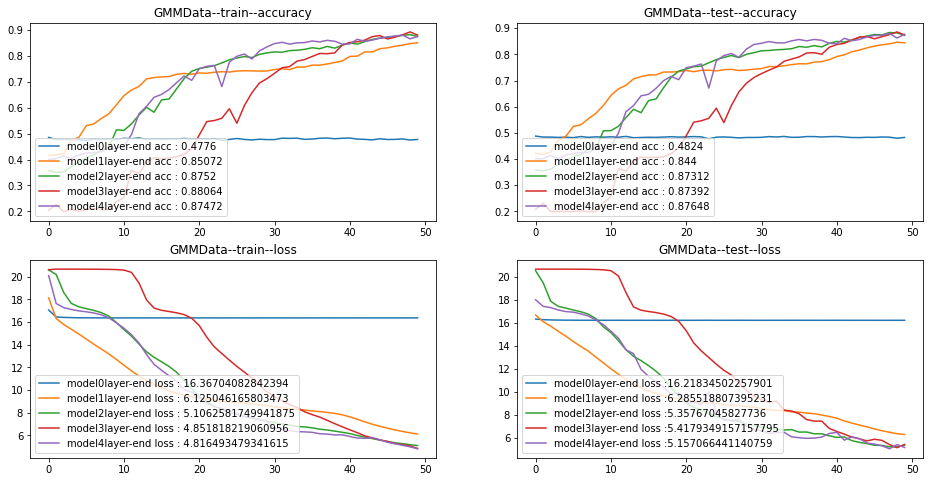

netrwork layers:[OutputLayer(2, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), HiddenLayer(6, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), HiddenLayer(6, 6), HiddenLayer(6, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), ResNetLayer(6, 6), HiddenLayer(6, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

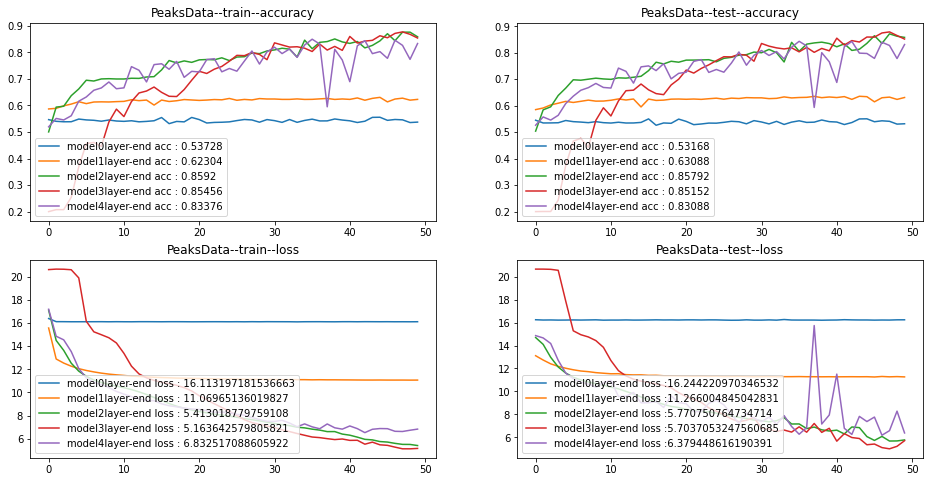

netrwork layers:[OutputLayer(2, 2)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), OutputLayer(6, 2)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), HiddenLayer(6, 6), OutputLayer(6, 2)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), HiddenLayer(6, 6), HiddenLayer(6, 6), OutputLayer(6, 2)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), ResNetLayer(6, 6), HiddenLayer(6, 6), OutputLayer(6, 2)]


  0%|          | 0/50 [00:00<?, ?it/s]

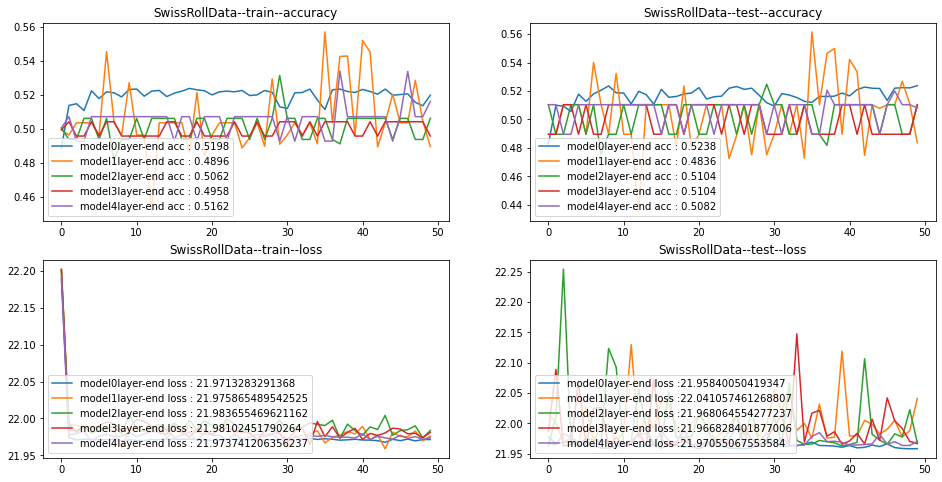

In [48]:
nets = [nn_linear,nn_lambda_2layer,nn_lambda_3layer,nn_lambda_4layer,nn_resnet]
for dataset in datasets:
    lst =[]
    for net in nets:
        acc = train_net(net,data_loader(dataset),epocs=50,lr=0.1,batch_size=64)
        lst.append(acc)

    lst = np.array(lst)

    lst_train_acc = lst[:,0,:]
    lst_train_loss = lst[:,1,:]
    lst_test_acc = lst[:,2,:]
    lst_test_loss = lst[:,3,:]
    

    fig, axs = plt.subplots(2, 2,figsize=(16,8))
    (ax1, ax2), (ax3, ax4) = axs
    for i,v in enumerate(lst_train_acc):
        ax1.set_title(f'{dataset}--train--accuracy')
        ax1.plot(v,label=f'model{i}layer-end acc : {v[-1]}')
        ax1.legend(loc=3)

    for i,v in enumerate(lst_test_acc):
        ax2.set_title(f'{dataset}--test--accuracy')
        ax2.plot(v,label=f'model{i}layer-end acc : {v[-1]}')
        ax2.legend(loc=3)
    
    for i,v in enumerate(lst_train_loss):
        ax3.set_title(f'{dataset}--train--loss')
        ax3.plot(v,label=f'model{i}layer-end loss : {v[-1]}')
        ax3.legend(loc=3)

    for i,v in enumerate(lst_test_loss):
        ax4.set_title(f'{dataset}--test--loss')
        ax4.plot(v,label=f'model{i}layer-end loss :{v[-1]}')
        ax4.legend(loc=3)
    
    
    
    
    plt.show()

# 2.2.5 - 200 data samples

In [49]:
def train_net_200points(net_lambda,data,epocs=200,lr=0.1,batch_size=64):
    Xtrain,Ytrain,Xtest,Ytest= data
    feature_num,examples_num = Xtrain.shape
    labels_num = Ytrain.shape[0]
    net = net_lambda(feature_num,labels_num,lr)
    print(f'netrwork layers:{net.layers}')
    # Train loop
    a_t = []
    a_v = []
    train_accuracy =[]
    val_accuracy =[]
    training_loss = []
    val_loss =[]
    for epoc in tqdm(range(epocs)):
        # Shuffle train data
        indices = np.arange(examples_num)
        np.random.shuffle(indices)
        Xtrain = Xtrain[:,indices]
        Ytrain = Ytrain[:,indices]
        
        Xtrain = Xtrain[:200]
        Ytrain = Ytrain[:200]
                        
        i = 0
        net.loss = 0
        while i * batch_size < 200:
            # Obtain minibatch
            batch_start = i * batch_size
            batch_end = min((i + 1) * batch_size, examples_num)

            minix = Xtrain[:,batch_start:batch_end]
            # transpoce the miniy to be inline with C
            miniy = Ytrain[:,batch_start:batch_end].T
            a_t.append(batch_end-batch_start)
            #forward pass
            net.forward(minix,miniy)

            #Backward+update nn params
            net.backward(miniy)

            #next batch...
            i += 1

        bias_fix = (i * batch_size - examples_num)/batch_size
        training_loss.append(net.loss/(i-1+bias_fix))
        train_accuracy.append(accuracy(net.predict(Xtrain),Ytrain.T))
        #training_loss.append(net.loss)

        # validation

        examples_num = Xtest.shape[1]
        indices = np.arange(examples_num)
        np.random.shuffle(indices)
        Xtest = Xtest[:,indices]
        Ytest = Ytest[:,indices]
        j = 0
        net.loss = 0

        while j * batch_size < examples_num:
            # Obtain minibatch
            batch_start = j * batch_size
            batch_end = min((j + 1) * batch_size, examples_num)

            minix = Xtest[:,batch_start:batch_end]
            # transpoce the miniy to be inline with C
            miniy = Ytest[:,batch_start:batch_end].T
            a_t.append(batch_end-batch_start)
            #forward pass
            net.forward(minix,miniy, training=False )

            #next batch...
            j += 1
        #val_loss.append(nn.loss)
        bias_fix = (j * batch_size - examples_num)/batch_size
        val_loss.append(net.loss/(j-1+bias_fix))
        val_accuracy.append(accuracy(net.predict(Xtest),Ytest.T))
    return train_accuracy,training_loss,val_accuracy,val_loss

netrwork layers:[OutputLayer(5, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(5, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(5, 6), HiddenLayer(6, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(5, 6), HiddenLayer(6, 6), HiddenLayer(6, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(5, 6), ResNetLayer(6, 6), HiddenLayer(6, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

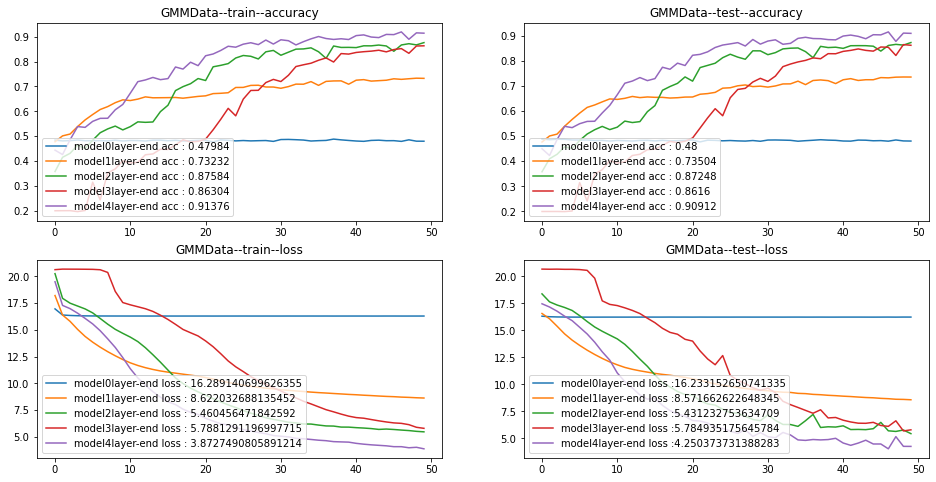

netrwork layers:[OutputLayer(2, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), HiddenLayer(6, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), HiddenLayer(6, 6), HiddenLayer(6, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), ResNetLayer(6, 6), HiddenLayer(6, 6), OutputLayer(6, 5)]


  0%|          | 0/50 [00:00<?, ?it/s]

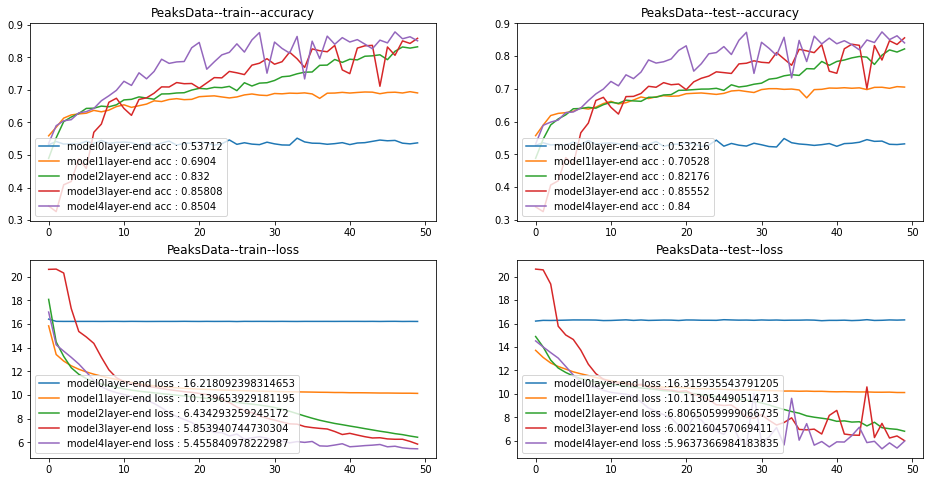

netrwork layers:[OutputLayer(2, 2)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), OutputLayer(6, 2)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), HiddenLayer(6, 6), OutputLayer(6, 2)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), HiddenLayer(6, 6), HiddenLayer(6, 6), OutputLayer(6, 2)]


  0%|          | 0/50 [00:00<?, ?it/s]

netrwork layers:[HiddenLayer(2, 6), ResNetLayer(6, 6), HiddenLayer(6, 6), OutputLayer(6, 2)]


  0%|          | 0/50 [00:00<?, ?it/s]

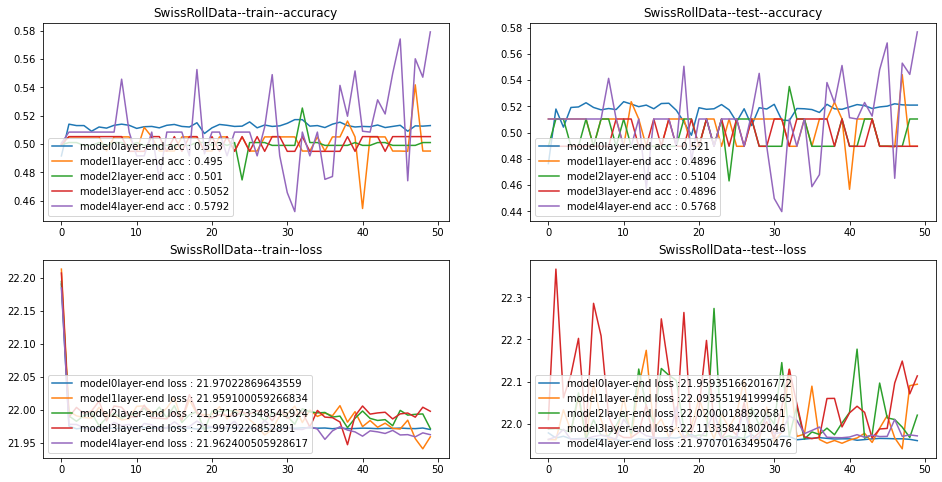

In [50]:
for dataset in datasets:
    lst =[]
    for net in nets:
        acc = train_net(net,data_loader(dataset),epocs=50,lr=0.1,batch_size=64)
        lst.append(acc)

    lst = np.array(lst)

    lst_train_acc = lst[:,0,:]
    lst_train_loss = lst[:,1,:]
    lst_test_acc = lst[:,2,:]
    lst_test_loss = lst[:,3,:]
    

    fig, axs = plt.subplots(2, 2,figsize=(16,8))
    (ax1, ax2), (ax3, ax4) = axs
    for i,v in enumerate(lst_train_acc):
        ax1.set_title(f'{dataset}--train--accuracy')
        ax1.plot(v,label=f'model{i}layer-end acc : {v[-1]}')
        ax1.legend(loc=3)

    for i,v in enumerate(lst_test_acc):
        ax2.set_title(f'{dataset}--test--accuracy')
        ax2.plot(v,label=f'model{i}layer-end acc : {v[-1]}')
        ax2.legend(loc=3)
    
    for i,v in enumerate(lst_train_loss):
        ax3.set_title(f'{dataset}--train--loss')
        ax3.plot(v,label=f'model{i}layer-end loss : {v[-1]}')
        ax3.legend(loc=3)

    for i,v in enumerate(lst_test_loss):
        ax4.set_title(f'{dataset}--test--loss')
        ax4.plot(v,label=f'model{i}layer-end loss :{v[-1]}')
        ax4.legend(loc=3)
    plt.show()